# Data Analysis of Fact-Checking Dataset

This notebook analyzes the fact-checking dataset, including fact checks, posts, and pairs.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Iterator
import ast
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import gc
from tqdm import tqdm

In [2]:
# Read the CSV file
df = pd.read_csv('fact_checks.csv')

# Function to extract information from the claim column
def process_claim(claim_str):
    claim_tuple = ast.literal_eval(claim_str)
    return {
        'claim': claim_tuple[0],
        'language': claim_tuple[2][0][0],
        'language_confidence': claim_tuple[2][0][1]
    }

# Function to extract information from the instances column
def process_instances(instances_str):
    instances = ast.literal_eval(instances_str)
    if instances:
        return {
            'timestamp': instances[0][0],
            'url': instances[0][1]
        }
    return {'timestamp': None, 'url': None}

# Apply the processing functions
claim_data = df['claim'].apply(process_claim).apply(pd.Series)
instance_data = df['instances'].apply(process_instances).apply(pd.Series)

# Combine the processed data
result_df = pd.concat([
    df['fact_check_id'],
    claim_data,
    instance_data
], axis=1)

# Reorder columns
result_df = result_df[[
    'fact_check_id', 'claim', 'language', 'language_confidence', 
    'timestamp', 'url'
]]

# Export to a new CSV file
result_df.to_csv('processed_fact_checks.csv', index=False)

In [3]:
df_facts = pd.read_csv('processed_fact_checks.csv')

In [4]:
df_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153743 entries, 0 to 153742
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fact_check_id        153743 non-null  int64  
 1   claim                153743 non-null  object 
 2   language             153743 non-null  object 
 3   language_confidence  153743 non-null  float64
 4   timestamp            150993 non-null  float64
 5   url                  153743 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 7.0+ MB


## 1. Analyzing fact_checks.csv

In [5]:
from urllib.parse import urlparse

# Read the CSV file
df = pd.read_csv('processed_fact_checks.csv')

# Language Distribution
language_data = df['language'].value_counts().reset_index()
language_data.columns = ['name', 'value']
print(language_data.to_dict('records'))

# Fact Checks Over Time
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
time_data = df['datetime'].dt.year.value_counts().sort_index().reset_index()
time_data.columns = ['year', 'count']
print(time_data.to_dict('records'))

# Top Domains
df['domain'] = df['url'].apply(lambda x: urlparse(x).netloc)
domain_data = df['domain'].value_counts().head(10).reset_index()
domain_data.columns = ['name', 'count']
print(domain_data.to_dict('records'))

# Claim Length Distribution
df['claim_length'] = df['claim'].str.len()
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '51-100', '101-150', '151-200', '201+']
df['claim_length_range'] = pd.cut(df['claim_length'], bins=bins, labels=labels, include_lowest=True)
claim_length_data = df['claim_length_range'].value_counts().sort_index().reset_index()
claim_length_data.columns = ['range', 'count']
print(claim_length_data.to_dict('records'))

[{'name': 'eng', 'value': 85734}, {'name': 'por', 'value': 21569}, {'name': 'ara', 'value': 14201}, {'name': 'spa', 'value': 14082}, {'name': 'msa', 'value': 8424}, {'name': 'deu', 'value': 4996}, {'name': 'fra', 'value': 4355}, {'name': 'tha', 'value': 382}]
[{'year': 1995.0, 'count': 2}, {'year': 1996.0, 'count': 13}, {'year': 1997.0, 'count': 22}, {'year': 1998.0, 'count': 47}, {'year': 1999.0, 'count': 96}, {'year': 2000.0, 'count': 148}, {'year': 2001.0, 'count': 164}, {'year': 2002.0, 'count': 84}, {'year': 2003.0, 'count': 107}, {'year': 2004.0, 'count': 169}, {'year': 2005.0, 'count': 354}, {'year': 2006.0, 'count': 288}, {'year': 2007.0, 'count': 726}, {'year': 2008.0, 'count': 416}, {'year': 2009.0, 'count': 315}, {'year': 2010.0, 'count': 267}, {'year': 2011.0, 'count': 473}, {'year': 2012.0, 'count': 330}, {'year': 2013.0, 'count': 417}, {'year': 2014.0, 'count': 733}, {'year': 2015.0, 'count': 1638}, {'year': 2016.0, 'count': 4728}, {'year': 2017.0, 'count': 5256}, {'year'

In [6]:
# Read the CSV file
df = pd.read_csv('processed_fact_checks.csv')

# Language Distribution
language_data = df['language'].value_counts().reset_index()
language_data.columns = ['name', 'value']
print(language_data.to_dict('records'))

# Fact Checks Over Time
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
time_data = df['datetime'].dt.year.value_counts().sort_index().reset_index()
time_data.columns = ['year', 'count']
print(time_data.to_dict('records'))

# Top Domains
df['domain'] = df['url'].apply(lambda x: urlparse(x).netloc)
domain_data = df['domain'].value_counts().head(10).reset_index()
domain_data.columns = ['name', 'count']
print(domain_data.to_dict('records'))

# Claim Length Distribution
df['claim_length'] = df['claim'].str.len()
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '51-100', '101-150', '151-200', '201+']
df['claim_length_range'] = pd.cut(df['claim_length'], bins=bins, labels=labels, include_lowest=True)
claim_length_data = df['claim_length_range'].value_counts().sort_index().reset_index()
claim_length_data.columns = ['range', 'count']
print(claim_length_data.to_dict('records'))

[{'name': 'eng', 'value': 85734}, {'name': 'por', 'value': 21569}, {'name': 'ara', 'value': 14201}, {'name': 'spa', 'value': 14082}, {'name': 'msa', 'value': 8424}, {'name': 'deu', 'value': 4996}, {'name': 'fra', 'value': 4355}, {'name': 'tha', 'value': 382}]
[{'year': 1995.0, 'count': 2}, {'year': 1996.0, 'count': 13}, {'year': 1997.0, 'count': 22}, {'year': 1998.0, 'count': 47}, {'year': 1999.0, 'count': 96}, {'year': 2000.0, 'count': 148}, {'year': 2001.0, 'count': 164}, {'year': 2002.0, 'count': 84}, {'year': 2003.0, 'count': 107}, {'year': 2004.0, 'count': 169}, {'year': 2005.0, 'count': 354}, {'year': 2006.0, 'count': 288}, {'year': 2007.0, 'count': 726}, {'year': 2008.0, 'count': 416}, {'year': 2009.0, 'count': 315}, {'year': 2010.0, 'count': 267}, {'year': 2011.0, 'count': 473}, {'year': 2012.0, 'count': 330}, {'year': 2013.0, 'count': 417}, {'year': 2014.0, 'count': 733}, {'year': 2015.0, 'count': 1638}, {'year': 2016.0, 'count': 4728}, {'year': 2017.0, 'count': 5256}, {'year'

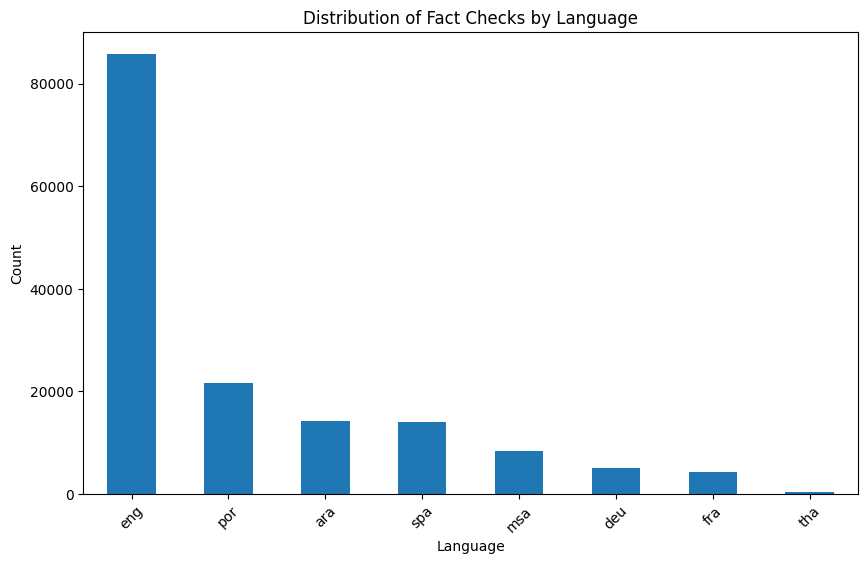

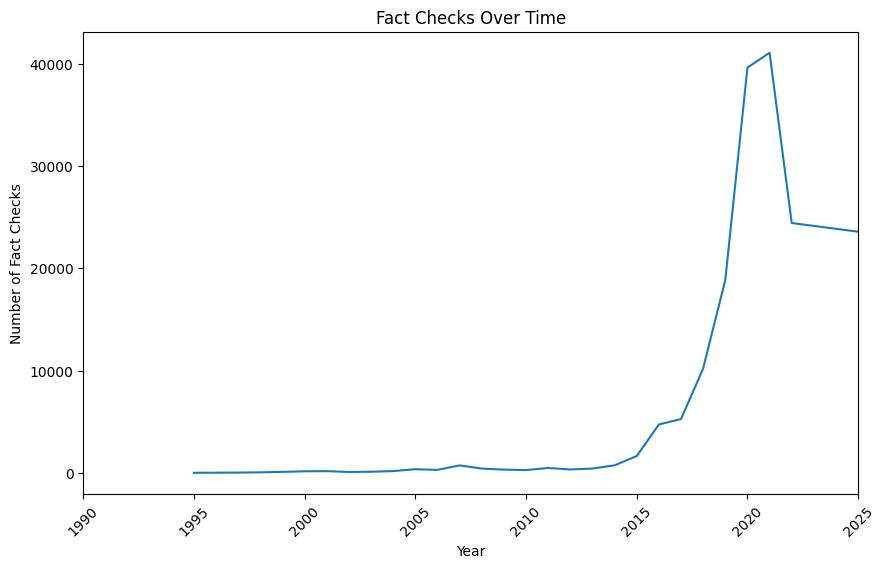

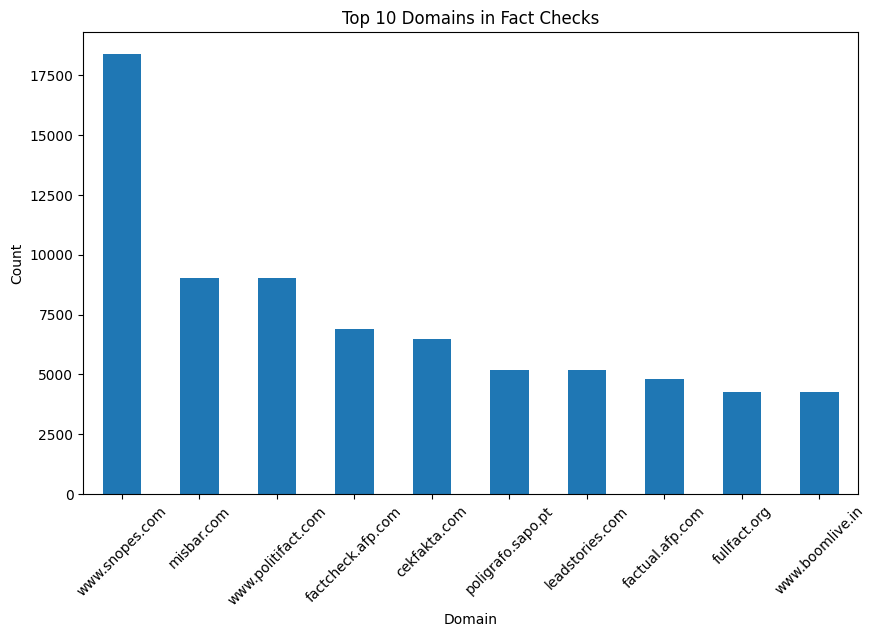

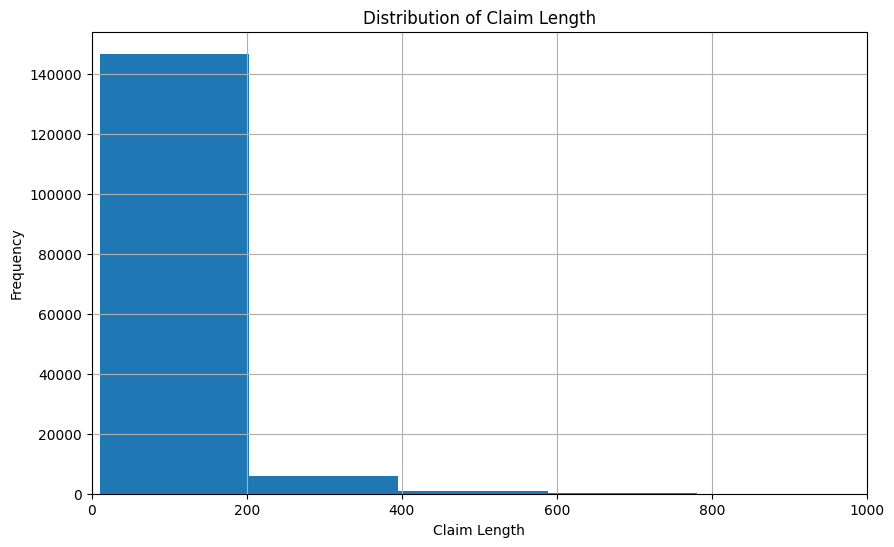

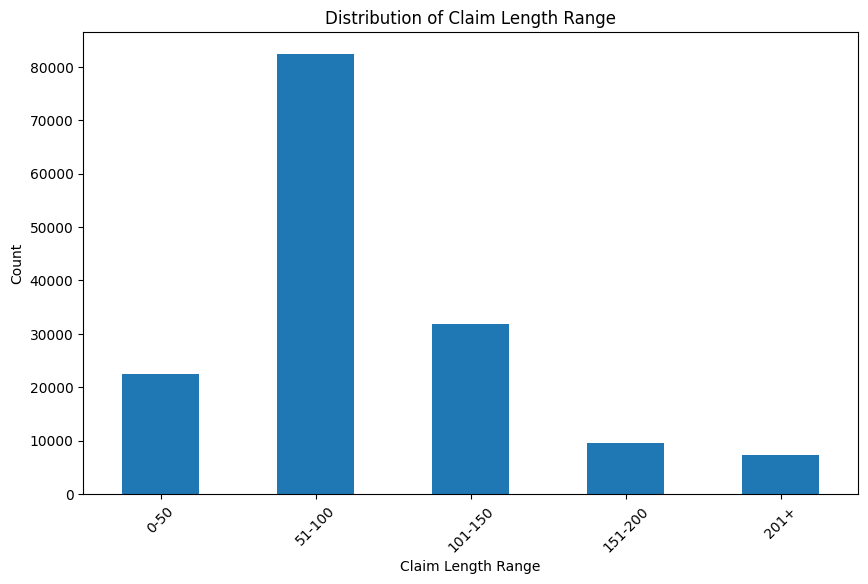

In [7]:
# Plot 1: Distribution of Fact Checks by Language
plt.figure(figsize=(10, 6))
df['language'].value_counts().plot(kind='bar')
plt.title('Distribution of Fact Checks by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Fact Checks Over Time
plt.figure(figsize=(10, 6))
df['datetime'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Fact Checks Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fact Checks')
plt.xlim(1990, 2025)
plt.xticks(rotation=45)
plt.show()

# Plot 3: Top Domains
plt.figure(figsize=(10, 6))
df['domain'] = df['url'].apply(lambda x: urlparse(x).netloc)
df['domain'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Domains in Fact Checks')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot 4: Claim Length Distribution
plt.figure(figsize=(10, 6))
df['claim_length'] = df['claim'].str.len()
df['claim_length'].hist(bins=50)
plt.title('Distribution of Claim Length')
plt.xlabel('Claim Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

# Plot 5: Claim Length Range Distribution
plt.figure(figsize=(10, 6))
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '51-100', '101-150', '151-200', '201+']
df['claim_length_range'] = pd.cut(df['claim_length'], bins=bins, labels=labels, include_lowest=True)
df['claim_length_range'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Claim Length Range')
plt.xlabel('Claim Length Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## 2. Analyzing posts.csv

In [8]:
import re

# Read the CSV file
df = pd.read_csv('posts.csv')

# Function to extract language codes from the ocr column
def extract_language_codes(ocr_str):
    # Use regex to find all language codes
    matches = re.findall(r"\('(\w+)',", ocr_str)
    
    # Remove duplicates while preserving order
    unique_languages = list(dict.fromkeys(matches))
    
    return unique_languages

# Apply the extraction function to the ocr column
df['languages'] = df['ocr'].apply(extract_language_codes)

# Function to format the languages column for readability
def format_languages(languages):
    return ', '.join(languages)

# Apply the formatting function
df['languages_formatted'] = df['languages'].apply(format_languages)

# Display the first few rows of the dataframe
print(df[['post_id', 'languages', 'languages_formatted']].head())

# Save the updated dataframe
df.to_csv('posts_with_language_codes.csv', index=False)

   post_id             languages languages_formatted
0        0             [deu, fy]             deu, fy
1        1                 [eng]                 eng
2        2                 [eng]                 eng
3        3  [fra, spa, deu, eng]  fra, spa, deu, eng
4        4                 [spa]                 spa


Total number of posts: 24431
Total language occurrences: 30802
Number of unique languages: 122
Posts with multiple languages: 8265 (33.83%)

Top 10 most common languages:
eng: 8713 (35.66%)
spa: 4578 (18.74%)
por: 3137 (12.84%)
fra: 1237 (5.06%)
msa: 871 (3.57%)
deu: 867 (3.55%)
ita: 855 (3.50%)
cat: 546 (2.23%)
ron: 516 (2.11%)
la: 510 (2.09%)

Top 5 language co-occurrences:
eng and spa: 1765
eng and por: 1195
por and spa: 974
fra and eng: 595
deu and eng: 393

Analysis complete. Details saved to 'language_analysis.txt' and chart saved as 'top_10_languages.png'.


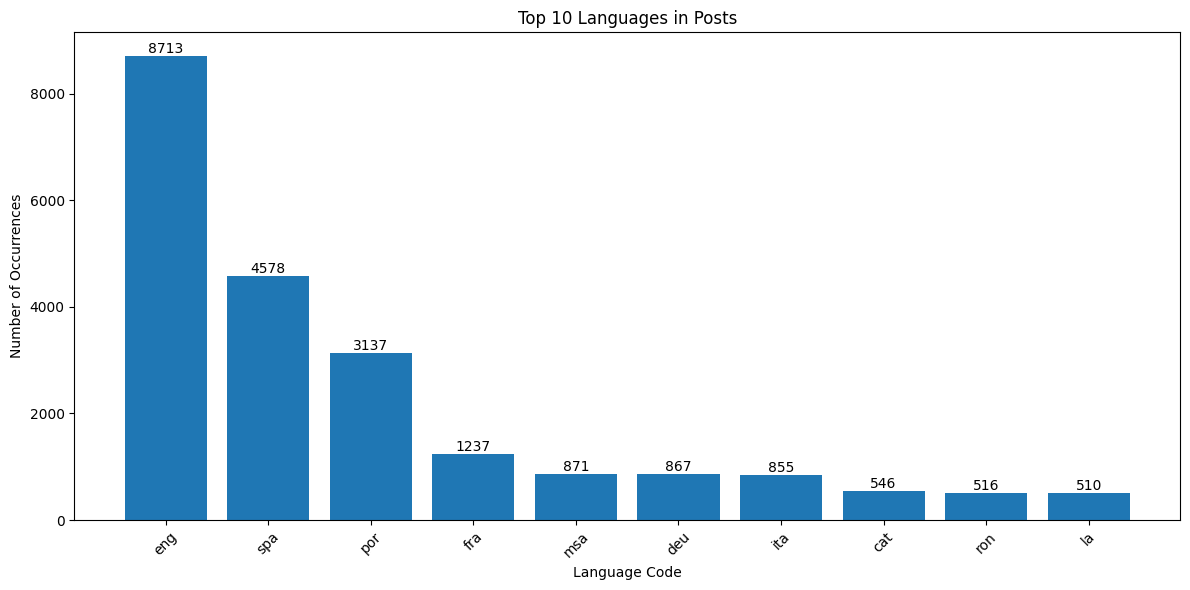

In [9]:
from collections import Counter

# Read the CSV file
posts = pd.read_csv('posts_with_language_codes.csv')

# Flatten the list of languages
all_languages = [lang for langs in posts['languages'].apply(eval) for lang in langs]

# Count the occurrences of each language
language_counts = Counter(all_languages)

# Calculate the total number of posts
total_posts = len(posts)

# Calculate statistics
total_languages = len(all_languages)
unique_languages = len(language_counts)
posts_with_multiple_languages = sum(len(langs) > 1 for langs in posts['languages'].apply(eval))

# Sort languages by frequency
sorted_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)

# Print summary statistics
print(f"Total number of posts: {total_posts}")
print(f"Total language occurrences: {total_languages}")
print(f"Number of unique languages: {unique_languages}")
print(f"Posts with multiple languages: {posts_with_multiple_languages} ({posts_with_multiple_languages/total_posts:.2%})")

print("\nTop 10 most common languages:")
for lang, count in sorted_languages[:10]:
    percentage = count / total_posts * 100
    print(f"{lang}: {count} ({percentage:.2f}%)")

# Plotting
plt.figure(figsize=(12, 6))
langs, counts = zip(*sorted_languages[:10])
plt.bar(langs, counts)
plt.title("Top 10 Languages in Posts")
plt.xlabel("Language Code")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45)
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('top_10_languages.png')

# Calculate and print language co-occurrences
print("\nTop 5 language co-occurrences:")
co_occurrences = Counter()
for langs in posts['languages'].apply(eval):
    if len(langs) > 1:
        co_occurrences.update(frozenset(pair) for pair in zip(langs, langs[1:]))

for pair, count in co_occurrences.most_common(5):
    print(f"{' and '.join(pair)}: {count}")

# Save detailed analysis to a text file
with open('language_analysis.txt', 'w') as f:
    f.write(f"Total number of posts: {total_posts}\n")
    f.write(f"Total language occurrences: {total_languages}\n")
    f.write(f"Number of unique languages: {unique_languages}\n")
    f.write(f"Posts with multiple languages: {posts_with_multiple_languages} ({posts_with_multiple_languages/total_posts:.2%})\n\n")
    
    f.write("Language distribution:\n")
    for lang, count in sorted_languages:
        percentage = count / total_posts * 100
        f.write(f"{lang}: {count} ({percentage:.2f}%)\n")
    
    f.write("\nTop 10 language co-occurrences:\n")
    for pair, count in co_occurrences.most_common(10):
        f.write(f"{' and '.join(pair)}: {count}\n")

print("\nAnalysis complete. Details saved to 'language_analysis.txt' and chart saved as 'top_10_languages.png'.")

## 3. Analyzing pairs.csv

In [10]:
print("\nAnalyzing pairs.csv:")
pairs = pd.read_csv('pairs.csv')
print(pairs.info())
print("\nSample of pairs:")
print(pairs.head())


Analyzing pairs.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25743 entries, 0 to 25742
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   post_id        25743 non-null  int64
 1   fact_check_id  25743 non-null  int64
dtypes: int64(2)
memory usage: 402.4 KB
None

Sample of pairs:
   post_id  fact_check_id
0     2228             33
1     2228          23568
2     2228         194577
3     2229             33
4     2229          23568


## 4. Basic statistics

In [11]:
print("\nBasic statistics:")
print(pairs.describe())


Basic statistics:
            post_id  fact_check_id
count  25743.000000   25743.000000
mean   13676.860428   87161.090044
std     8058.215487   44379.242976
min        0.000000      33.000000
25%     6692.000000   52377.500000
50%    13544.000000   82464.000000
75%    20434.500000  121278.500000
max    28091.000000  202891.000000


## 5. Check for data integrity

In [12]:
# Check for missing values in df_facts
missing_values_df_facts = df_facts.isnull().sum()
print("Missing values in df_facts:")
print(missing_values_df_facts)

# Check for missing values in pairs
missing_values_pairs = pairs.isnull().sum()
print("\nMissing values in pairs:")
print(missing_values_pairs)

# Check for missing values in posts
missing_values_posts = posts.isnull().sum()
print("\nMissing values in posts:")
print(missing_values_posts)

# Check for duplicate entries in df_facts
duplicate_entries_df_facts = df_facts.duplicated().sum()
print("\nDuplicate entries in df_facts:")
print(duplicate_entries_df_facts)

# Check for duplicate entries in pairs
duplicate_entries_pairs = pairs.duplicated().sum()
print("\nDuplicate entries in pairs:")
print(duplicate_entries_pairs)

# Check for duplicate entries in posts
duplicate_entries_posts = posts.duplicated().sum()
print("\nDuplicate entries in posts:")
print(duplicate_entries_posts)

# Verify relationships between datasets
# Check if all fact_check_id in pairs exist in df_facts
missing_fact_check_ids = pairs[~pairs['fact_check_id'].isin(df_facts['fact_check_id'])]
print("\nMissing fact_check_id in df_facts:")
print(missing_fact_check_ids)

# Check if all post_id in pairs exist in posts
missing_post_ids = pairs[~pairs['post_id'].isin(posts['post_id'])]
print("\nMissing post_id in posts:")
print(missing_post_ids)

Missing values in df_facts:
fact_check_id             0
claim                     0
language                  0
language_confidence       0
timestamp              2750
url                       0
dtype: int64

Missing values in pairs:
post_id          0
fact_check_id    0
dtype: int64

Missing values in posts:
post_id                    0
instances                  0
ocr                        0
verdicts                   0
text                    2454
languages                  0
languages_formatted    11439
dtype: int64

Duplicate entries in df_facts:
0

Duplicate entries in pairs:
0

Duplicate entries in posts:
0

Missing fact_check_id in df_facts:
Empty DataFrame
Columns: [post_id, fact_check_id]
Index: []

Missing post_id in posts:
Empty DataFrame
Columns: [post_id, fact_check_id]
Index: []


## 6. Analyze text length

In [13]:
# Analyze text length in fact checks dataset
df_facts['claim_length'] = df_facts['claim'].str.len()
claim_length_stats = df_facts['claim_length'].describe()
print("Fact Checks Text Length Statistics:")
print(claim_length_stats)

# Analyze text length in posts dataset
posts['text_length'] = posts['text'].str.len()
text_length_stats = posts['text_length'].describe()
print("\nPosts Text Length Statistics:")
print(text_length_stats)

Fact Checks Text Length Statistics:
count    153743.000000
mean         96.039677
std          81.370315
min          10.000000
25%          60.000000
50%          80.000000
75%         111.000000
max        9647.000000
Name: claim_length, dtype: float64

Posts Text Length Statistics:
count    21977.000000
mean       785.600400
std       1513.858287
min         26.000000
25%        171.000000
50%        332.000000
75%        708.000000
max      64349.000000
Name: text_length, dtype: float64


In [14]:
posts.columns

Index(['post_id', 'instances', 'ocr', 'verdicts', 'text', 'languages',
       'languages_formatted', 'text_length'],
      dtype='object')

In [15]:
posts['text']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4                                                      NaN
                               ...                        
24426    ('🧐Se separó el presidente...la constitución d...
24427                       ('🧐🧐🧐', '🧐🧐🧐', [('eng', 1.0)])
24428    ('🧬Robert Malone, inventeur de la technologie ...
24429    ('🧵Enquanto você se distrai com a invasão da R...
24430    ('🧿 대통령은 아바타... "대통령님, 말문 막히시면 원론적인 답변부터 하시며 시...
Name: text, Length: 24431, dtype: object

In [16]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Define the stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the claim column
df_facts['claim_no_stopwords'] = df_facts['claim'].apply(remove_stopwords)

# Display the first few rows to verify
print(df_facts[['claim', 'claim_no_stopwords']].head())

[nltk_data] Downloading package stopwords to /home/shuja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             claim  \
0                       Are avocados good for you?   
1                      Can animals have headaches?   
2       Can we help prevent Alzheimer's with diet?   
3   Do any benefits of alcohol outweigh the risks?   
4             Does acupuncture work for headaches?   

                 claim_no_stopwords  
0                avocados good you?  
1                animals headaches?  
2    help prevent Alzheimer's diet?  
3  benefits alcohol outweigh risks?  
4       acupuncture work headaches?  


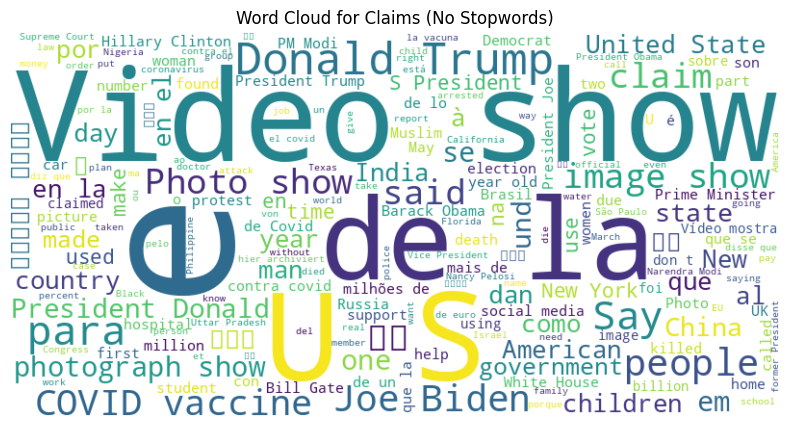

In [17]:
from wordcloud import WordCloud

# Combine all the text from the claim_no_stopwords column
text = ' '.join(df_facts['claim_no_stopwords'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Claims (No Stopwords)')
plt.show()

In [18]:
# import medspacy
# from medspacy.ner import TargetMatcher
# from medspacy.section_detection import Sectionizer

# # Install MedSpaCy if not already installed

# # Load the MedSpaCy model
# nlp = medspacy.load()

# # Add components to the pipeline
# target_matcher = TargetMatcher(nlp)
# sectionizer = Sectionizer(nlp)

In [19]:
# # filter out medical terms from df_facts using medspacy
# def filter_medical_terms(text):
#     doc = nlp(text)
#     filtered_text = ' '.join([ent.text for ent in doc.ents if ent.label_ == 'PROBLEM'])
#     return filtered_text

# # Apply the function to the claim column
# df_facts['claim_medical_terms'] = df_facts['claim'].apply(filter_medical_terms)

# # Display the first few rows to verify
# print(df_facts[['claim', 'claim_medical_terms']].head())

# # Combine all the text from the claim_medical_terms column
# medical_text = ' '.join(df_facts['claim_medical_terms'])

In [20]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# pipe = pipeline("fill-mask", model="google-bert/bert-base-multilingual-cased")

In [21]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
# model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-cased")

In [22]:
# import torch
# from transformers import AutoTokenizer, AutoModelForMaskedLM
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # Move model to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Function to encode text into embeddings
# def encode_text(text, tokenizer, model):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
#     inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.logits.mean(dim=1).squeeze().cpu().numpy()  # Move output to CPU

# # Example social media posts (SMP) and fact-checks (FC)
# smp_texts = posts['ocr'].tolist()
# fc_texts = df_facts['claim_no_stopwords'].tolist()

# # Encode SMP and FC texts
# smp_embeddings = np.array([encode_text(text, tokenizer, model) for text in smp_texts])
# fc_embeddings = np.array([encode_text(text, tokenizer, model) for text in fc_texts])

# # Compute cosine similarity between SMP and FC embeddings
# similarity_matrix = cosine_similarity(smp_embeddings, fc_embeddings)

# # Function to compute mean reciprocal rank (MRR)
# def mean_reciprocal_rank(similarity_matrix):
#     ranks = []
#     for i in range(similarity_matrix.shape[0]):
#         sorted_indices = np.argsort(-similarity_matrix[i])
#         rank = np.where(sorted_indices == i)[0][0] + 1
#         ranks.append(1 / rank)
#     return np.mean(ranks)

# # Function to compute success @ K
# def success_at_k(similarity_matrix, k):
#     success = 0
#     for i in range(similarity_matrix.shape[0]):
#         sorted_indices = np.argsort(-similarity_matrix[i])
#         if i in sorted_indices[:k]:
#             success += 1
#     return success / similarity_matrix.shape[0]

# # Compute MRR and success @ K
# mrr = mean_reciprocal_rank(similarity_matrix)
# success_k = success_at_k(similarity_matrix, k=3)

# print(f"Mean Reciprocal Rank (MRR): {mrr}")
# print(f"Success @ K (K=3): {success_k}")

In [23]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
def batched_cosine_similarity(embeddings1: np.ndarray, 
                            embeddings2: np.ndarray, 
                            batch_size: int = 1000) -> np.ndarray:
    """
    Calculate cosine similarity in batches to avoid memory issues
    """
    similarity_matrix = np.zeros((len(embeddings1), len(embeddings2)))
    
    # Convert to torch tensors for faster computation
    if not torch.is_tensor(embeddings1):
        embeddings1 = torch.from_numpy(embeddings1)
        embeddings2 = torch.from_numpy(embeddings2)
    
    # Normalize the embeddings
    embeddings1_normalized = torch.nn.functional.normalize(embeddings1, p=2, dim=1)
    embeddings2_normalized = torch.nn.functional.normalize(embeddings2, p=2, dim=1)
    
    # Process in batches
    for i in tqdm(range(0, len(embeddings1), batch_size), desc="Computing similarities"):
        batch_embeddings1 = embeddings1_normalized[i:i + batch_size]
        
        # Process second dimension in batches too
        for j in range(0, len(embeddings2), batch_size):
            batch_embeddings2 = embeddings2_normalized[j:j + batch_size]
            
            # Compute similarity for this batch
            batch_similarity = torch.mm(batch_embeddings1, batch_embeddings2.t())
            
            # Store in the main similarity matrix
            similarity_matrix[i:i + batch_size, j:j + batch_size] = batch_similarity.cpu().numpy()
            
        # Clear GPU memory if needed
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return similarity_matrix

In [35]:
def stream_cosine_similarity(embeddings1: np.ndarray, 
                           embeddings2: np.ndarray, 
                           batch_size: int = 100,
                           top_k: int = 5) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """
    Stream computation of top-k similar items without materializing full similarity matrix
    """
    # Convert to torch tensors and move to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if not torch.is_tensor(embeddings2):
        embeddings2 = torch.from_numpy(embeddings2).to(device, dtype=torch.float32)
    
    # Normalize embeddings2 once
    embeddings2_normalized = torch.nn.functional.normalize(embeddings2, p=2, dim=1)
    
    # Process first set of embeddings in batches
    for i in tqdm(range(0, len(embeddings1), batch_size), desc="Computing similarities"):
        batch_embeddings1 = embeddings1[i:i + batch_size]
        
        # Convert and normalize batch
        if not torch.is_tensor(batch_embeddings1):
            batch_embeddings1 = torch.from_numpy(batch_embeddings1).to(device, dtype=torch.float32)
        batch_embeddings1 = torch.nn.functional.normalize(batch_embeddings1, p=2, dim=1)
        
        # Initialize arrays for top k results
        batch_top_scores = torch.full((len(batch_embeddings1), top_k), float('-inf'), device=device)
        batch_top_indices = torch.zeros((len(batch_embeddings1), top_k), dtype=torch.long, device=device)
        
        # Process second set in batches
        for j in range(0, len(embeddings2), batch_size):
            batch_embeddings2 = embeddings2_normalized[j:j + batch_size]
            
            # Compute similarities for this mini-batch
            similarities = torch.mm(batch_embeddings1, batch_embeddings2.t())
            
            # Update top k for each query in current batch
            for query_idx in range(similarities.shape[0]):
                scores = similarities[query_idx]
                top_scores, top_indices = torch.topk(scores, min(top_k, len(scores)))
                
                # Merge with existing top k
                all_scores = torch.cat([batch_top_scores[query_idx], top_scores])
                all_indices = torch.cat([batch_top_indices[query_idx], top_indices + j])
                
                merged_scores, merged_indices = torch.topk(all_scores, top_k)
                batch_top_scores[query_idx] = merged_scores
                batch_top_indices[query_idx] = all_indices[merged_indices]
            
            # Clear GPU memory
            del similarities
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Convert results to CPU and yield
        yield (
            batch_top_indices.cpu().numpy(),
            batch_top_scores.cpu().numpy()
        )
        
        # Clear batch GPU memory
        del batch_embeddings1, batch_top_scores, batch_top_indices
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

In [36]:
def retrieve_claims_minilm(smp_texts: List[str], 
                         fc_texts: List[str], 
                         batch_size: int = 32,
                         top_k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Memory-efficient retrieval using MiniLM with streaming similarity computation
    """
    # Load model
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    print("Encoding social media posts...")
    smp_embeddings = model.encode(
        smp_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    print("Encoding fact checks...")
    fc_embeddings = model.encode(
        fc_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    print("Computing top-k similarities...")
    # Initialize arrays for final results
    all_top_indices = np.zeros((len(smp_texts), top_k), dtype=np.int64)
    all_top_scores = np.zeros((len(smp_texts), top_k), dtype=np.float32)
    
    # Process in streaming fashion
    current_idx = 0
    for batch_indices, batch_scores in stream_cosine_similarity(
        smp_embeddings, 
        fc_embeddings,
        batch_size=batch_size,
        top_k=top_k
    ):
        batch_size = len(batch_indices)
        all_top_indices[current_idx:current_idx + batch_size] = batch_indices
        all_top_scores[current_idx:current_idx + batch_size] = batch_scores
        current_idx += batch_size
        
        # Force garbage collection
        gc.collect()
    
    return all_top_indices, all_top_scores

In [26]:
# Solution 2: Using LaBSE (Language-agnostic BERT Sentence Embedding)
from transformers import AutoTokenizer, AutoModel
import torch

class LaBSERetriever:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('setu4993/LaBSE')
        self.model = AutoModel.from_pretrained('setu4993/LaBSE')
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def encode_batch(self, texts, batch_size=16):
        all_embeddings = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            
            # Tokenize and prepare input
            encoded_input = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,  # Reduced from 512 for speed
                return_tensors='pt'
            ).to(self.device)
            
            # Compute token embeddings
            with torch.no_grad():
                model_output = self.model(**encoded_input)
            
            # Perform pooling
            embeddings = self.mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            
            all_embeddings.append(embeddings.cpu().numpy())
        
        return np.vstack(all_embeddings)
    
    def retrieve_claims(self, smp_texts, fc_texts):
        smp_embeddings = self.encode_batch(smp_texts)
        fc_embeddings = self.encode_batch(fc_texts)
        return cosine_similarity(smp_embeddings, fc_embeddings)

In [27]:
# Solution 3: Using FastText (very lightweight but still decent for multilingual)
import fasttext
import fasttext.util

def retrieve_claims_fasttext(smp_texts, fc_texts):
    # Download and load the model (only needed once)
    fasttext.util.download_model('en', if_exists='ignore')
    ft = fasttext.load_model('cc.en.300.bin')
    
    def get_text_embedding(text):
        # Average word vectors for the text
        words = text.lower().split()
        word_vectors = [ft.get_word_vector(word) for word in words]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        return np.zeros(ft.get_dimension())
    
    # Generate embeddings
    smp_embeddings = np.array([get_text_embedding(text) for text in smp_texts])
    fc_embeddings = np.array([get_text_embedding(text) for text in fc_texts])
    
    return cosine_similarity(smp_embeddings, fc_embeddings)

In [28]:
# Evaluation functions
def mean_reciprocal_rank(similarity_matrix):
    ranks = []
    for i in range(similarity_matrix.shape[0]):
        sorted_indices = np.argsort(-similarity_matrix[i])
        rank = np.where(sorted_indices == i)[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)

def success_at_k(similarity_matrix, k):
    success = 0
    for i in range(similarity_matrix.shape[0]):
        sorted_indices = np.argsort(-similarity_matrix[i])
        if i in sorted_indices[:k]:
            success += 1
    return success / similarity_matrix.shape[0]

In [29]:
def retrieve_top_k(similarity_matrix: np.ndarray, 
                   k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get top K matches for each query
    """
    top_k_indices = np.argpartition(-similarity_matrix, k, axis=1)[:, :k]
    top_k_scores = similarity_matrix[np.arange(similarity_matrix.shape[0])[:, None], top_k_indices]
    
    # Sort the top K results
    top_k_ordering = np.argsort(-top_k_scores, axis=1)
    top_k_indices = top_k_indices[np.arange(top_k_indices.shape[0])[:, None], top_k_ordering]
    top_k_scores = top_k_scores[np.arange(top_k_scores.shape[0])[:, None], top_k_ordering]
    
    return top_k_indices, top_k_scores

In [30]:
def evaluate_retrieval(similarity_matrix: np.ndarray, 
                      true_pairs: List[Tuple[int, int]], 
                      k_values: List[int] = [1, 3, 5, 10]) -> dict:
    """
    Memory-efficient evaluation
    """
    metrics = {}
    
    # Calculate MRR
    mrr = 0
    for query_idx, relevant_idx in true_pairs:
        # Get ranks for this query
        rankings = np.argsort(-similarity_matrix[query_idx])
        rank = np.where(rankings == relevant_idx)[0][0] + 1
        mrr += 1 / rank
    metrics['mrr'] = mrr / len(true_pairs)
    
    # Calculate Success@K
    for k in k_values:
        success = 0
        for query_idx, relevant_idx in true_pairs:
            top_k = np.argpartition(-similarity_matrix[query_idx], k)[:k]
            if relevant_idx in top_k:
                success += 1
        metrics[f'success@{k}'] = success / len(true_pairs)
    
    return metrics

In [37]:
def evaluate_retrieval_streaming(smp_texts: List[str],
                               fc_texts: List[str],
                               true_pairs: List[Tuple[int, int]],
                               batch_size: int = 32,
                               k_values: List[int] = [1, 3, 5, 10]) -> dict:
    """
    Memory-efficient evaluation using streaming similarity computation
    """
    max_k = max(k_values)
    
    # Get top-k matches for all queries
    top_k_indices, top_k_scores = retrieve_claims_minilm(
        smp_texts,
        fc_texts,
        batch_size=batch_size,
        top_k=max_k
    )
    
    metrics = {}
    
    # Calculate metrics
    mrr = 0
    success_counts = {k: 0 for k in k_values}
    
    for query_idx, relevant_idx in true_pairs:
        # Find position of relevant document in top-k results
        try:
            rank = np.where(top_k_indices[query_idx] == relevant_idx)[0][0] + 1
            mrr += 1 / rank
            
            # Update success@k counts
            for k in k_values:
                if rank <= k:
                    success_counts[k] += 1
        except IndexError:
            # Relevant document not in top-k
            pass
    
    # Compute final metrics
    metrics['mrr'] = mrr / len(true_pairs)
    for k in k_values:
        metrics[f'success@{k}'] = success_counts[k] / len(true_pairs)
    
    return metrics

In [ ]:
# Example usage
if __name__ == "__main__":
    smp_texts = posts['ocr'].tolist()
    fc_texts = df_facts['claim_no_stopwords'].tolist()
    
    # Process in smaller batches
    print("Running retrieval with memory-efficient implementation...")
    sim_matrix = retrieve_claims_minilm(
        smp_texts, 
        fc_texts,
        batch_size=32,            # Encoding batch size
        similarity_batch_size=1000 # Similarity computation batch size
    )
    
    # Example evaluation
    true_pairs = [(0, 0), (1, 1)]  # Replace with your actual pairs
    metrics = evaluate_retrieval(sim_matrix, true_pairs)
    
    print("\nResults:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")
    
    # Get top K matches for each query
    k = 5
    top_k_indices, top_k_scores = retrieve_top_k(sim_matrix, k)
    
    print(f"\nTop {k} matches for each query:")
    for i in range(len(smp_texts)):
        print(f"\nQuery {i}:")
        for j in range(k):
            idx = top_k_indices[i][j]
            score = top_k_scores[i][j]
            print(f"  Match {j+1}: Index {idx}, Score {score:.3f}")

In [ ]:
if __name__ == "__main__":
    # Example data
    smp_texts = posts['ocr'].tolist()
    fc_texts = df_facts['claim_no_stopwords'].tolist()
    true_pairs = [(0, 0), (1, 1)]
    
    print("Running memory-efficient retrieval...")
    metrics = evaluate_retrieval_streaming(
        smp_texts,
        fc_texts,
        true_pairs,
        batch_size=8
    )
    
    print("\nResults:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

Running memory-efficient retrieval...
Encoding social media posts...


Batches: 100%|██████████| 3054/3054 [01:19<00:00, 38.63it/s]


Encoding fact checks...


Batches: 100%|██████████| 19218/19218 [05:09<00:00, 62.11it/s]


Computing top-k similarities...


Computing similarities:   4%|▍         | 137/3054 [1:38:54<36:19:41, 44.83s/it]